Очень рекомендую посмотреть видео от Глеба Михайлова!)<br>
**[Линейная Регрессия для Дата Саентиста](https://www.youtube.com/watch?v=QZJ94igWVxQ&t=19s)**     <br> 
    
**Вот здесь есть отличное объяснение с примером по [мультиколлинеарности](https://habr.com/ru/company/akbarsdigital/blog/592493/)** <br>
    
**И здесь интересная статься - [коротко о мультиколлинеарности и что с этим делать](https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666)** <br>   
   
**Если интересна статистика, можно посмотреть [короткие видео-лекции Карпова на степике](https://stepik.org/lesson/8095/step/1?unit=1371)**    <br>

**Вот здесь, как мне кажется, есть неплохая статья про [смысл техники bootstrap](https://habr.com/ru/company/X5Tech/blog/679842/)**<br>

**Видео-лекция на степике -  [3 раздел - Введение в bootstrap](https://stepik.org/course/2152/syllabus)** <br> 

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах: <br>
/datasets/geo_data_0.csv <br>
/datasets/geo_data_1.csv <br>
/datasets/geo_data_2.csv <br>
id — уникальный идентификатор скважины; <br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы); <br>
product — объём запасов в скважине (тыс. баррелей). <br>

### Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). <br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. <br>
Бюджет на разработку скважин в регионе — 10 млрд рублей. <br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. <br>
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. <br>
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются. <br>

## Загрузка и подготовка данных

In [1]:
#загрузим библиотеки 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

In [2]:
#Загрузим данные 
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#Проведем предобраблтку данных 
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data_0.duplicated().sum()

0

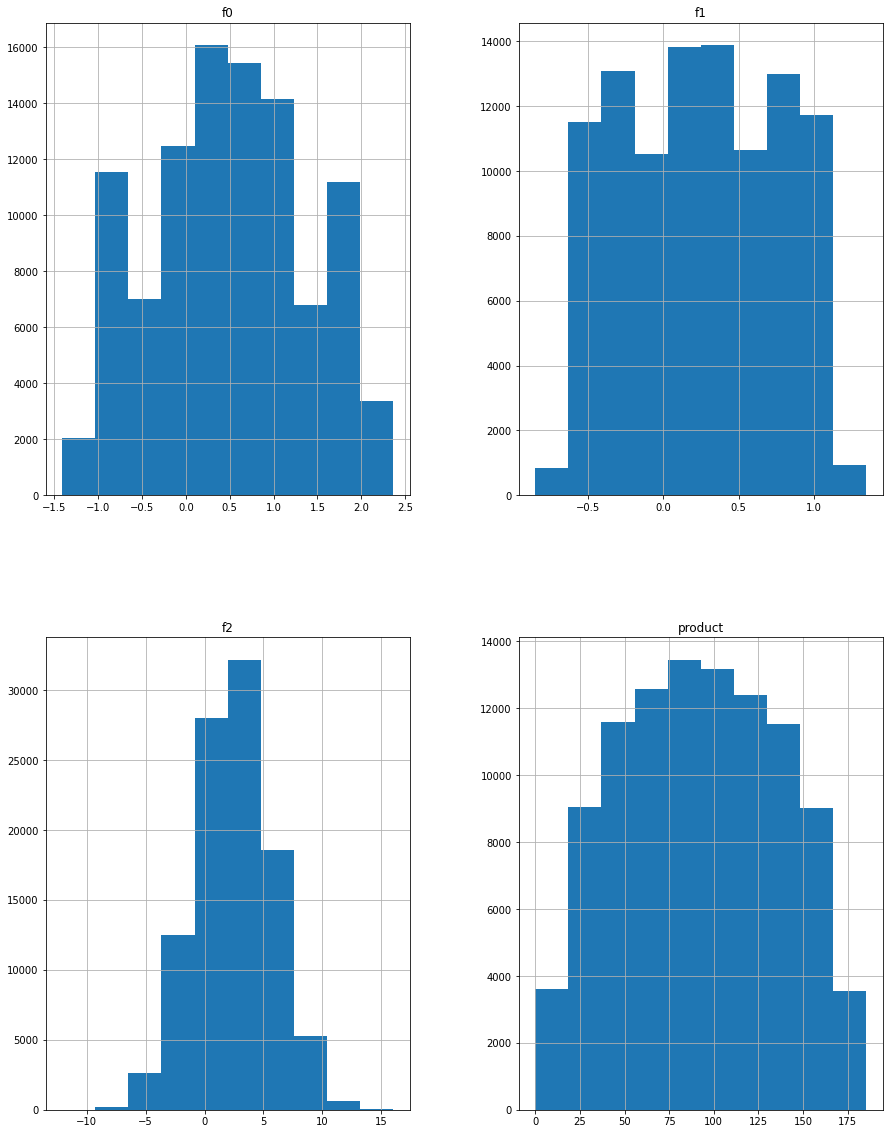

In [7]:
data_0.hist(figsize = (15,20));

<AxesSubplot:>

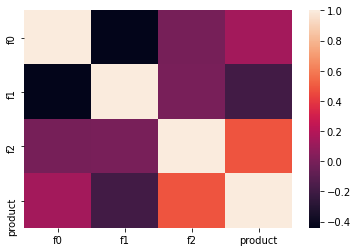

In [8]:
#heatmap для первого датасета
sns.heatmap(data_0.corr())

In [9]:
data_0["id"].duplicated().sum()

10

In [10]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [13]:
data_1.duplicated().sum()

0

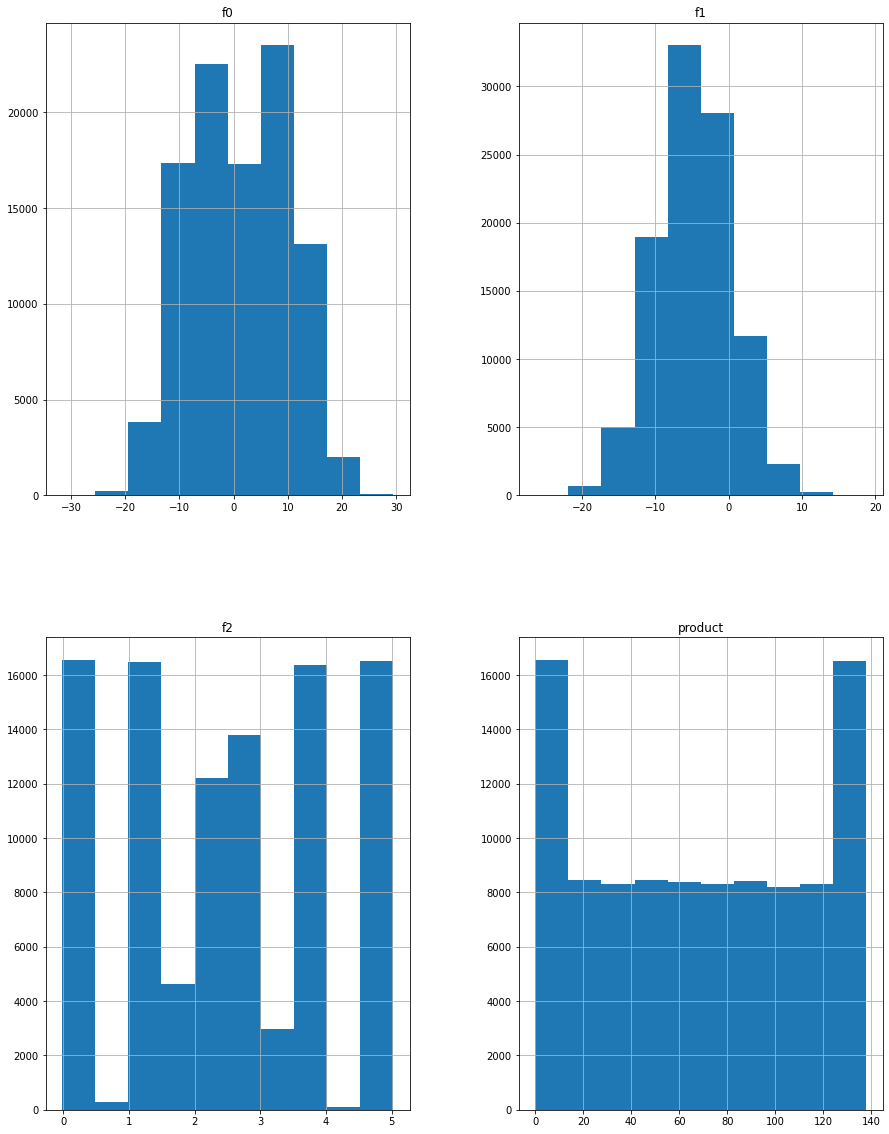

In [14]:
data_1.hist(figsize = (15,20));

<AxesSubplot:>

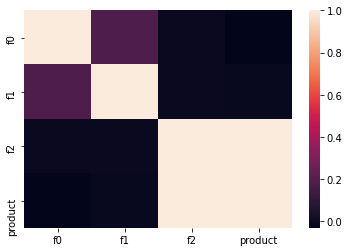

In [15]:
#heatmap для второго датасета
sns.heatmap(data_1.corr())

In [16]:
data_1["id"].duplicated().sum()

4

In [17]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [18]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [19]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


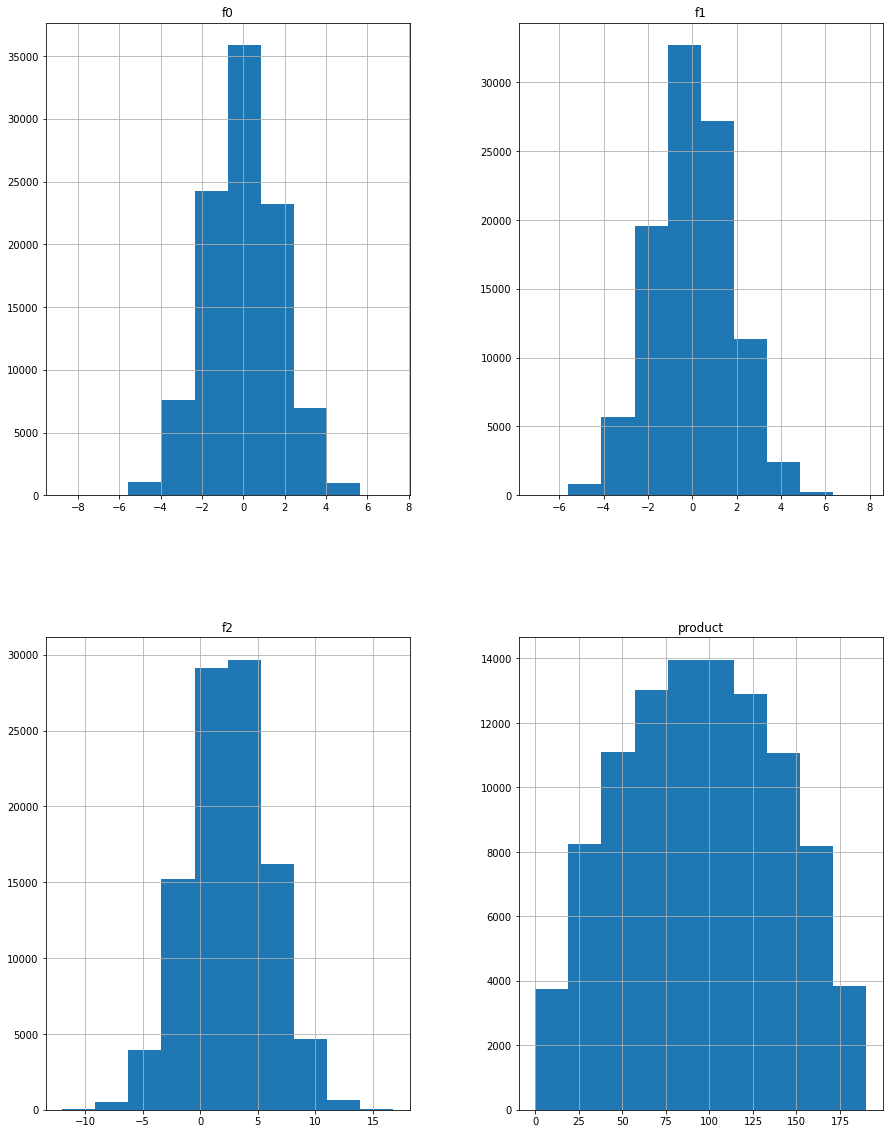

In [20]:
data_2.hist(figsize = (15,20));

In [21]:
data_2.duplicated().sum()

0

<AxesSubplot:>

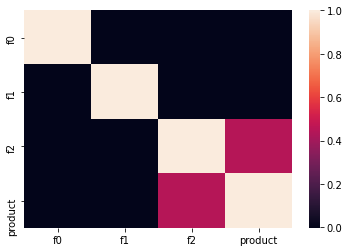

In [22]:
#heatmap для третьего датасета
sns.heatmap(data_2.corr())

In [23]:
data_2["id"].duplicated().sum()

4

Вывод: данные загружены и требуется дополнительная предобработка по удалению дупликатов в каждом датасете по id

<b>Совет:</b><br>
* Чтобы лучше узнать данные, можно проверить дубликаты по `id`    

* Еще важно уделять внимание мультиколлинеарности признаков в линейных моделях.<br>
Мультиколлинеарность — явление, при котором наблюдается сильная корреляция между признаками, что может негативно отразиться на модели.<br>

Рекомендую посмотреть отрывок из курса Статистики - ["Корреляция и регрессия".](https://stepik.org/lesson/8086/step/1?unit=1365) <br>
Для удобной визуализации можно использовать - ["Тепловая карта корреляции".](https://www.delftstack.com/ru/howto/seaborn/correlation-heatplot-seaborn-python/) <br>
</div>

In [24]:
data_0 = data_0.drop_duplicates(subset=['id'])
data_1 = data_1.drop_duplicates(subset=['id'])
data_2 = data_2.drop_duplicates(subset=['id'])

## Обучение и проверка модели

Перед разбивкой данных и обучением моделей, прbменим OrdinalEncoder
Затем разобьём данные на обучающую и валидационную выборки в соотношении 75:25

In [25]:
#2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 
#ПЕрвый регион
data_0_without_ID = data_0.drop("id", axis = 1)

encoder_0 = OrdinalEncoder() 
encoder_0.fit(data_0_without_ID)

data_ordinal_0 = pd.DataFrame(encoder_0.transform(data_0_without_ID), columns=data_0_without_ID.columns)


target_0=data_0_without_ID['product']
features_0=data_0_without_ID.drop(['product'], axis=1)

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=42)
len_t_v=target_valid_0.shape[0]/target_0.shape[0]
len_t_t=target_train_0.shape[0]/target_0.shape[0]

print('Размер тренировочной выборки 1 датасета- {:.0%}'.format(len_t_t))
print('Размер валидационной выборки 1 датасета - {:.0%}'.format(len_t_v))

Размер тренировочной выборки 1 датасета- 75%
Размер валидационной выборки 1 датасета - 25%


<div class="alert alert-block alert-warning"><b>Комментарий ревьюера V-2</b>
    
<b>Совет:</b><br>
Код с применением  `OrdinalEncoder()` лишний, т.к. в этом проекте нет категориальных признаков.   
    
```python
encoder_0 = OrdinalEncoder() 
encoder_0.fit(data_0_without_ID)

data_ordinal_0 = pd.DataFrame(encoder_0.transform(data_0_without_ID), columns=data_0_without_ID.columns)
    
```   
    
Лучше для каждого региона эту часть кода убрать.    
</div>

In [26]:
#Второй регион
data_1_without_ID = data_1.drop("id", axis = 1)

encoder_1 = OrdinalEncoder() 
encoder_1.fit(data_1_without_ID)

data_ordinal_1 = pd.DataFrame(encoder_1.transform(data_1_without_ID), columns=data_1_without_ID.columns)

target_1=data_1_without_ID['product']
features_1=data_1_without_ID.drop(['product'], axis=1)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=42)
len_t_v=target_valid_1.shape[0]/target_1.shape[0]
len_t_t=target_train_1.shape[0]/target_1.shape[0]

print('Размер тренировочной выборки 2го датасета- {:.0%}'.format(len_t_v))
print('Размер валидационной выборки 2го датасета - {:.0%}'.format(len_t_t))

Размер тренировочной выборки 2го датасета- 25%
Размер валидационной выборки 2го датасета - 75%


In [27]:
#Третий регион
data_2_without_ID = data_2.drop("id", axis = 1)

encoder_2 = OrdinalEncoder() 
encoder_2.fit(data_2_without_ID)
data_ordinal_2 = pd.DataFrame(encoder_2.transform(data_2_without_ID), columns = data_2_without_ID.columns)


target_2=data_2_without_ID['product']
features_2=data_2_without_ID.drop(['product'], axis=1)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=42)
len_t_v=target_valid_2.shape[0]/target_2.shape[0]
len_t_t=target_train_2.shape[0]/target_2.shape[0]

print('Размер тренировочной выборки 3го датасета- {:.0%}'.format(len_t_t))
print('Размер валидационной выборки 3го датасета- {:.0%}'.format(len_t_v))

Размер тренировочной выборки 3го датасета- 75%
Размер валидационной выборки 3го датасета- 25%


  <b>Совет:</b><br>
Оставлю совет для будущих проектов))<br>
`При кодировании/масштабировании обучаем только на трейне!)`    
</div>

In [28]:
#2.2. Обучим модель и сделаем предсказания на валидационной выборке.
#Первая модель
model_0=LinearRegression()
model_0.fit(features_train_0,target_train_0)
predict_0=model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predict_0)**0.5
r2_score_0 = r2_score(target_valid_0, predict_0)
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_0)
print('Коэффициент детерминации: %.2f' % r2_score_0)

Среднеквадратичная ошибка RMSE: 37.69
Коэффициент детерминации: 0.27


In [29]:
#Вторая модель
model_1=LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1=model_1.predict(features_valid_1)
rmse_1=mean_squared_error(target_valid_1, predict_1)**0.5
r2_score_1 = r2_score(target_valid_1, predict_1)
print('Среднеквадратичная ошибка RMSE: %.2f' % rmse_1)
print('Коэффициент детерминации: %.2f' % r2_score_1)

Среднеквадратичная ошибка RMSE: 0.89
Коэффициент детерминации: 1.00


In [30]:
#Третья модель
model_2=LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2=model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
r2_score_2 = r2_score(target_valid_2, predict_2)
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
print('Коэффициент детерминации: %.2f' % r2_score_2)

Среднеквадратичная ошибка RMSE: 40.08
Коэффициент детерминации: 0.19


<b>Совет:</b><br>
Для каждого региона действия повторяются, в таких случаях удобно использовать функцию. Это позволит не писать один и тот же код несколько раз и избегать ошибок. В случае необходимых изменений, достаточно поправить функцию, а не вносить правки несколько раз.<br>
<br>    
Например, в функцию можно поместить разбиение на выборки,  обучение, расчет метрики, среднего предсказанного запаса и вернуть таргет_валид, предсказания с соответствующими друг другу индексами.   
</div>

In [31]:
#2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
print('1 регион:\n- предсказания модели: "predict_0"\n- правильные ответы: "target_valid_0"')
print()
print('2 регион:\n- предсказания модели: "predict_1"\n- правильные ответы: "target_valid_1"')
print()
print('3 регион:\n- предсказания модели: "predict_2"\n- правильные ответы: "target_valid_2"')

1 регион:
- предсказания модели: "predict_0"
- правильные ответы: "target_valid_0"

2 регион:
- предсказания модели: "predict_1"
- правильные ответы: "target_valid_1"

3 регион:
- предсказания модели: "predict_2"
- правильные ответы: "target_valid_2"


In [32]:
tabl = pd.DataFrame(index=['Среднее по предсказанию','RMSE модели', 'R2_score'])
tabl['Первый регион'] = predict_0.mean(), rmse_0, r2_score_0
tabl['Второй регион'] = predict_1.mean(), rmse_1, r2_score_1
tabl['Третий регион'] = predict_2.mean(), rmse_2, r2_score_2
print(tabl)

                         Первый регион  Второй регион  Третий регион
Среднее по предсказанию      92.609840      68.577035      94.934787
RMSE модели                  37.685089       0.892827      40.080822
R2_score                      0.274539       0.999623       0.194846


2.5. Проанализируем результаты. <br>
**Вывод**
Модели обучены и проверены на качество предсказания метрикой RMSE с помощью метода машинного обучения LinearRegression. Величина RMSE и  R2-score во втором регионе сильно отличается от первого и третьего регионов. Скорее всего модель обучилась на практически равных по величине данных.

Обращаем внимание на размер ошибки, в двух других регионах она катастрофически большая - почти 40% от  среднего запаса. Если ошибка (RMSE) меньше, значит прогноз точнее и модель лучше обучилась. Если посмотреть корреляцию между признаками и целевой переменной, можно понять почему в одном из регионов ошибка минимальная. Высокий коэффициент корреляции `f2` и целевой переменной говорит о сильной прямой линейной зависимости.
<br>    
Т.к. средний запас в каждом регионе ниже объема безубыточности и при выборе скважин опираемся на предсказания, то качество предсказания имеет огромное значение - важно определить скважины с максимальным запасом.     
</div>  

## Подготовка к расчёту прибыли

#3.1. Все ключевые значения для расчётов сохраните в отдельных переменных. <br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [33]:
#Подготовьтесь к расчёту прибыли:
#3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
point_for_ml = 200 #200 Точек для разработки с помощью машинного обучения
cash = 10 ** 7 #Бюджет на разработку скважин в регионе, тыс.руб
income = 450 #Доход с каждой единицы продукта, тыс.руб
target_probability_losses = 2.5/100 # вероятность убытков

<b>Совет:</b><br>
* Согласно руководству по написанию кода на Python [PEP-8](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-29) названия констант принято задавать заглавными буквами, например, `BUDGET`. А еще важно объявлять их в начале проекта после импортов, затем загрузка данных. Так проще будет их найти и изменить, если возникнет такая необходимость.
* Для записи больших чисел можно использовать экспоненциальную запись числа - `1e7`, что означает 1 * 10**7.    
</div>

In [34]:
#3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. 
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()
print('Cредний запас сырья в 1 регионе: %.2f млн.баррелей'%product_mean_0)
print('Cредний запас сырья в 2 регионе: %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 3 регионе: %.2f млн.баррелей'%product_mean_2)

Cредний запас сырья в 1 регионе: 92.50 млн.баррелей
Cредний запас сырья в 2 регионе: 68.82 млн.баррелей
Cредний запас сырья в 3 регионе: 95.00 млн.баррелей


In [35]:
cash_for_1_point = (cash/point_for_ml)# тыс.руб
print('Бюджет на разработку одной скважины:', cash_for_1_point/1000,'млн.руб')
#Рассчитаем достаточный объём сырья для безубыточной разработки новой скважин

v_prod = cash_for_1_point/income
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Бюджет на разработку одной скважины: 50.0 млн.руб
Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


In [36]:
#Сравним полученный объём сырья со средним запасом в каждом регионе.

#Первый регион
print("Сравнение полученного объема сырья со средним запасом в первом регионе")
data_0['profit'] = (data_0['product'] * (income)).round(2) # profit, тыс.руб
print(data_0.head())
print()
print("Значение ROI для каждой скважины по отношению к затратам на разработку")
data_0['roi_%'] = ((data_0['profit'] - cash_for_1_point)/cash_for_1_point*100).round(2)
print(data_0.head())
print()
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_0/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod - product_mean_0))

Сравнение полученного объема сырья со средним запасом в первом регионе
      id        f0        f1        f2     product    profit
0  txEyH  0.705745 -0.497823  1.221170  105.280062  47376.03
1  2acmU  1.334711 -0.340164  4.365080   73.037750  32866.99
2  409Wp  1.022732  0.151990  1.419926   85.265647  38369.54
3  iJLyR -0.032172  0.139033  2.978566  168.620776  75879.35
4  Xdl7t  1.988431  0.155413  4.751769  154.036647  69316.49

Значение ROI для каждой скважины по отношению к затратам на разработку
      id        f0        f1        f2     product    profit  roi_%
0  txEyH  0.705745 -0.497823  1.221170  105.280062  47376.03  -5.25
1  2acmU  1.334711 -0.340164  4.365080   73.037750  32866.99 -34.27
2  409Wp  1.022732  0.151990  1.419926   85.265647  38369.54 -23.26
3  iJLyR -0.032172  0.139033  2.978566  168.620776  75879.35  51.76
4  Xdl7t  1.988431  0.155413  4.751769  154.036647  69316.49  38.63

Разница объёма сырья для безубыточной разработки скважины относительно среднего зн

In [37]:
#Второй регион
print("Сравнение полученного объема сырья со средним запасом во втором регионе")
data_1['profit'] = (data_1['product'] * income).round(2) # profit, тыс.руб
data_1.head()
print()
print("Значение ROI для каждой скважины по отношению к затратам на разработку")
data_1['roi_%'] = ((data_1['profit'] - cash_for_1_point)/cash_for_1_point*100).round(2)
data_1.head()
print()
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: {:.2%}'.format(product_mean_1/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod - product_mean_1))

Сравнение полученного объема сырья со средним запасом во втором регионе

Значение ROI для каждой скважины по отношению к затратам на разработку

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: -38.06%
Или 42.29 тыс.баррелей


In [38]:
#Третий регион
print("Сравнение полученного объема сырья со средним запасом в третьем регионе")
data_2['profit'] = (data_2['product'] * income).round(2) # profit, тыс.руб
print(data_2.head())
print()
print("Значение ROI для каждой скважины по отношению к затратам на разработку")
data_2['roi_%'] = ((data_2['profit'] - cash_for_1_point)/cash_for_1_point*100).round(2)
print(data_2.head())
print()

print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: {:.2%}'.format(product_mean_2/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod - product_mean_2))

Сравнение полученного объема сырья со средним запасом в третьем регионе
      id        f0        f1        f2     product    profit
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673  12491.40
1  WJtFt  0.262778  0.269839 -2.530187   56.069697  25231.36
2  ovLUW  0.194587  0.289035 -5.586433   62.871910  28292.36
3  q6cA6  2.236060 -0.553760  0.930038  114.572842  51557.78
4  WPMUX -0.515993  1.716266  5.899011  149.600746  67320.34

Значение ROI для каждой скважины по отношению к затратам на разработку
      id        f0        f1        f2     product    profit  roi_%
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673  12491.40 -75.02
1  WJtFt  0.262778  0.269839 -2.530187   56.069697  25231.36 -49.54
2  ovLUW  0.194587  0.289035 -5.586433   62.871910  28292.36 -43.42
3  q6cA6  2.236060 -0.553760  0.930038  114.572842  51557.78   3.12
4  WPMUX -0.515993  1.716266  5.899011  149.600746  67320.34  34.64

Разница объёма сырья для безубыточной разработки скважины относительно среднего з

In [39]:
#3.3. Напишишем выводы по этапу подготовки расчёта прибыли.

**Вывод:**



Исходя из полученных данных становится очевидно, что среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b><br>
    
В каждом регионе средний объем сырья меньше достаточного объёма для безубыточности. Есть 25 000 точек, из которых надо выбрать 200. В результате, среди этих скважин могут быть скважины с достаточным и недостаточным запасом сырья. <br>
    
**При выборе скважин опираемся на предсказания, поэтому точность прогноза имеет большое значение** и без модели нам не обойтись.<br>  
    
Главная задача - выбрать скважины с достаточным запасом сырья. <br>    

    
   
</div>

In [40]:
#Создадим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели

In [41]:
probs_sorted_0 = pd.Series(predict_0, index=target_valid_0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:point_for_ml]
#Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
selected_max_0_sum = selected_max_0.sum()
print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max_0_sum)

Суммарный запас сырья в 200 лучших скважинах составит: 31007.79 тыс.баррелей


## Расчёт прибыли и рисков 

In [42]:
#Рассчитаем прибыль для полученного объёма сырья
#Для первого регион
profit_pred_0 = (selected_max_0_sum * income) - cash
print('Прибыль для полученного объёма сырья составит %.2f тыс.рублей'%profit_pred_0)

Прибыль для полученного объёма сырья составит 3953505.89 тыс.рублей


In [43]:
#Сдалаем функцию
def profit_pv(predict,target,count):
    probs_sorted = pd.Series(predict, index = target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max * income) - cash
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [44]:
#Первый регион
profit_pv(predict_0,target_valid_0,200)

Суммарный запас сырья в 200 лучших скважинах составит: 31007.79 тыс.баррелей
Прибыль для полученного объёма сырья составит 3953.51 млн.рублей


In [45]:
#Второй регион

profit_pv(predict_1,target_valid_1,200)

Суммарный запас сырья в 200 лучших скважинах составит: 27740.13 тыс.баррелей
Прибыль для полученного объёма сырья составит 2483.06 млн.рублей


In [46]:
#Третий регион
profit_pv(predict_2,target_valid_2,200)

Суммарный запас сырья в 200 лучших скважинах составит: 29607.80 тыс.баррелей
Прибыль для полученного объёма сырья составит 3323.51 млн.рублей


Все три региона потенциально прибыльные
Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [47]:
def profit_for_vp2(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * income
    return revenue - cash

In [48]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample,target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))


### Совет
При семплировании данных нужно устанавливаешь `replace = True`, это необходимо чтобы наблюдение в выборку попало несколько раз, что позволяет добиться независимости при каждом выборе, иначе вероятность достать элемент из выборки будет с каждым разом увеличиваться. Чем больше размер подвыборки, тем выраженнее будет зависимость, поэтому без возврата не удастся получить разнообразные варианты, а подвыборку бОльшего размера вообще не получить.

Почему именно так. Вспомним, что выборка - это некоторое представление о генеральной совокупности, ее часть. Значит, что где-то в регионе существуют и другие потенциальные точки добычи нефти, о которых мы можем не знать, но они являются частью этой генеральной совокупности. В этом случае повторяющиеся наблюдения можно считать разными точками добычи из всей генеральной совокупности с близкими характеристиками.
    
</div>  

  0%|          | 0/1000 [00:00<?, ?it/s]

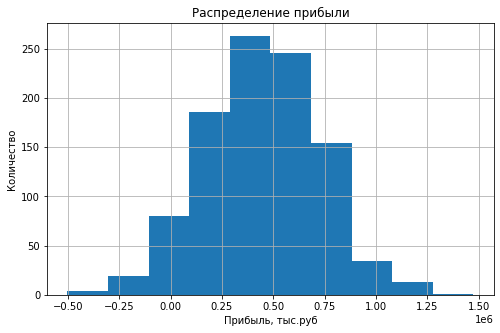

Средняя прибыль: 447.53 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -91.01 млн.руб до: 997.54 млн.руб
95%-ый доверительный интервал: от 430.18 млн.руб до 464.88 млн.руб
Процент вероятности убытка в данном регионе составит 5.3%


In [49]:
#Распределение прибыли 1 регион
bootstap_1000(target_valid_0,predict_0)

  0%|          | 0/1000 [00:00<?, ?it/s]

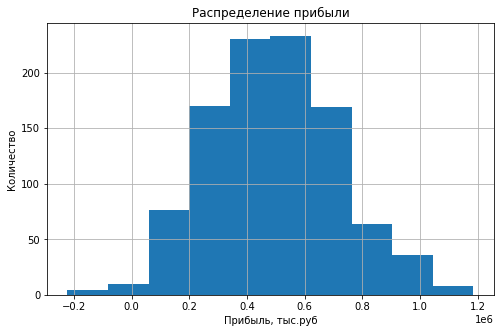

Средняя прибыль: 491.07 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 95.23 млн.руб до: 960.07 млн.руб
95%-ый доверительный интервал: от 477.25 млн.руб до 504.89 млн.руб
Процент вероятности убытка в данном регионе составит 0.7%


In [50]:
#Распределение прибыли 2 регион
bootstap_1000(target_valid_1,predict_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

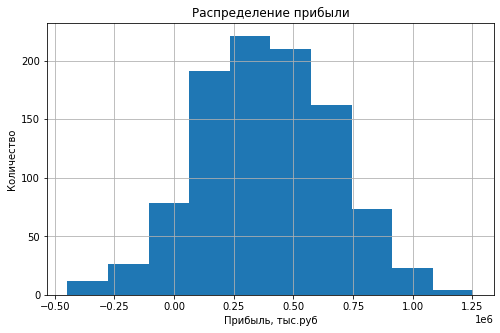

Средняя прибыль: 383.79 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -180.22 млн.руб до: 916.98 млн.руб
95%-ый доверительный интервал: от 366.42 млн.руб до 401.15 млн.руб
Процент вероятности убытка в данном регионе составит 7.8%


In [51]:
#Распределение прибыли 3 регион
bootstap_1000(target_valid_2,predict_2)

<div class="alert alert-block alert-success"><b>Комментарий ревьюера </b><br>
    

Здесь ты используешь `st.t.interval` и `quantile`. На всякий случай оставлю разъяснение в чем разница :)  <br>
`st.t.interval` показывает, что существует вероятность `95%`, что доверительный интервал `(..., ...)` содержит `....mean()`.  <br>
<br>    
  
Что такое  `quantile()` очень хорошо объясняет пример - 0.5-й квантиль, это, по сути, медиана, т.е. функция `quantile(0.5)` должна вернуть такое значение, которое меньше ровно половины элементов массива.<br>  
`quantile(0.025)` находит такое значение прибыли,  меньше которого только 2,5% элементов. И если это значение прибыли положительное, значит и риск меньше 2,5%. <br>
Выбирая наугад 1000 раз 500 случайных скважин и отбирая из них 200 лучших, убыток получаем менее, чем в 2,5% случаев.  
</div>

Выбор региона

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью
Сравним среднюю прибыль, вероятность убытка и суммарный запас сырья трёх представленных регионов в таблице


In [52]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = '435.84', profit_pred_0,'6.2'
comparison_tabl['2 регион'] = '489.66', '27748.75','1.1'
comparison_tabl['3 регион'] = '403.95', '29730.68','7.0'
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн.руб",435.84,489.66,403.95
"Суммарный запас сырья, тыс.баррелей",3953505.894022,27748.75,29730.68
"Вероятность убытка, %",6.2,1.1,7.0


<div class="alert alert-block alert-warning"><b>Комментарий ревьюера</b>
    
<b>Совет:</b><br>
Лучше значения введенные вручную заменить кодом. Если будут изменения в проекте, такие значения не изменятся автоматически, возникнет ошибка в выводах. <br>  
</div>

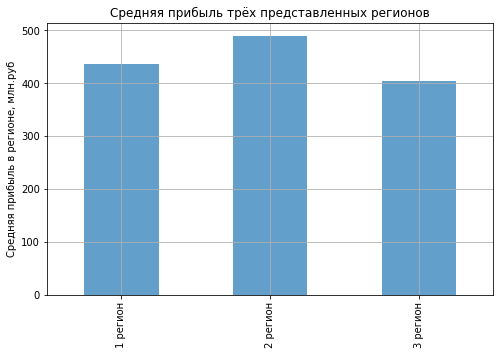

In [53]:
comparison_tabl.astype('float').iloc[0,:].plot(kind="bar", figsize=(8,5), grid=True, alpha=0.7, subplots=True)
plt.title('Средняя прибыль трёх представленных регионов')
plt.ylabel('Средняя прибыль в регионе, млн.руб')
plt.show()

***Вывод***

Согласно распределению среднего значения прибыли с региона, самым прибыльным оказался 2 регион, средняя прибыль в этом регионе составит 489.66 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%. Таким образом не смотря на то, что там меньше всего запасы сырья средняя доходность со скважин во втором регионе прогнозируется выше других.


    👍 Регион `geo_data_1` выбран абсолютно верно. В этом регионе минимальный % риска, т.к. модель предсказывает хорошо (ошибка минимальная). А при выборе 200 лучших скважин мы опираемся на предсказания, поэтому ничего удивительного  -  регион победил!)
    
</div>  